# Code Demo

## Title: Efficient AI: Bridging the Gap with Knowledge Distillation Techniques
### Student Name: Sharanya Nallapeddi
UB Person Name: snallape, UB Person Number: 50593866

Real time scenario:
Consider working in a hospital where a cutting-edge artificial intelligence model (the "teacher") can read medical scans (MRIs, X-rays, etc.) with high accuracy. However, this model is large and requires powerful GPUs to operate. Our task is to create a smaller AI model—the "student"—that can be deployed on phones in remote clinics with limited processing resources. By copying the "knowledge" from the big teacher model to a small student model, knowledge distillation makes it useful without losing (most of) the teacher's performance.

What is knowledge distillation?
1. https://blog.roboflow.com/what-is-knowledge-distillation/
2. https://medium.com/@subhashve4/how-deepseek-r1s-distilled-models-differ-from-the-real-thing-a-guide-to-knowledge-distillation-0d3d46dd8a9e#:~:text=Knowledge%20distillation%20is%20a%20technique,as%20smartphones%20or%20edge%20hardware.


We would conduct a series of experiments here with the purpose of improving the accuracy of a light-weight network using a more powerful network, also called a teacher. The computational cost and the speed of the light-weight network will remain unchanged, our action being only on its weights, not on its forward pass.

Applications of this technology are in devices such as drones or mobiles. In the code below, we do not use any third-party packages because all we need is included in torch and torchvision.

Issues taken care of in the code below are:

1. How to modify model classes to receive hidden representations & how to use them for further calculations

2. How to apply standard train loops in PyTorch to introduce additional losses over, e.g., cross-entropy for classification

3. How to boost the performance of light models using more advanced models as teachers

In [ ]:
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()
device = accelerator.device
print(f"Using {device} device for the Distillation Techniques")

Using cuda device for the Distillation Techniques


In this demo, we would be working on CIFAR-10 dataset (And, its downloaded by the script & saved in a directory called /data).

Below is the code snippet to load CIFAR-10 dataset.

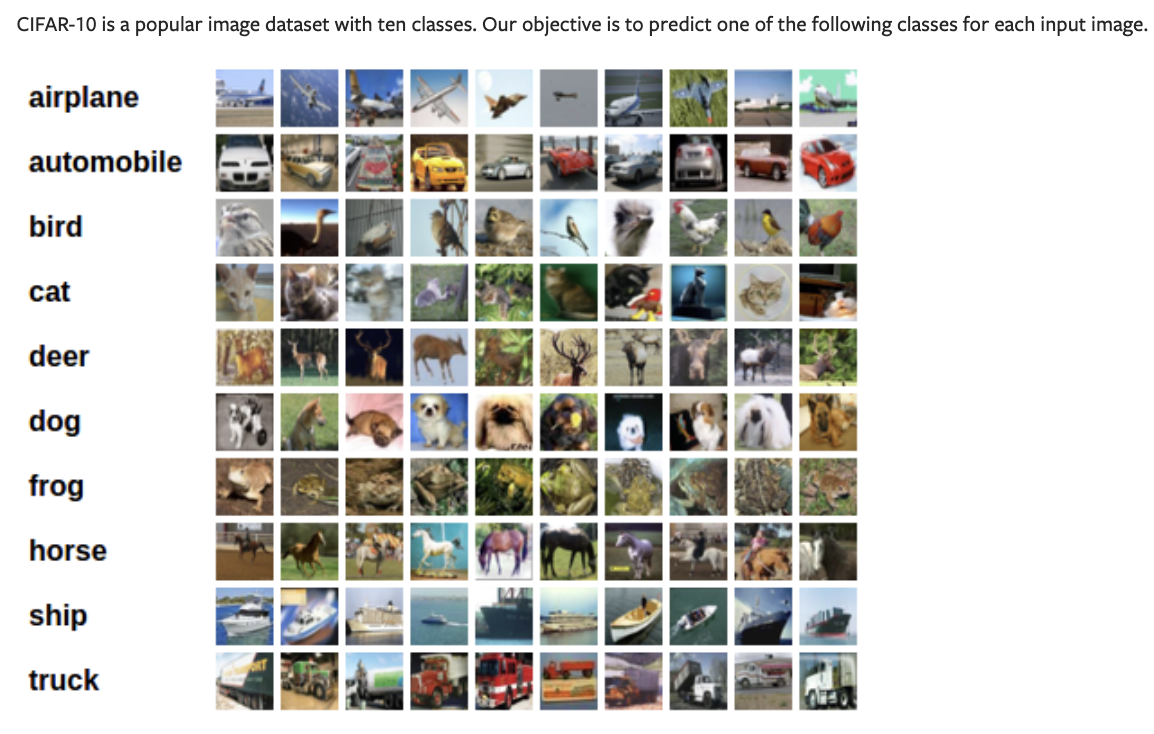

The RGB input images are 32x32 pixels with three channels. In essence, 3 x 32 x 32 = 3072 integers, ranging from 0 to 255, characterize each image.


In [ ]:
transformsCifarDataset = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformsCifarDataset)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformsCifarDataset)

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
#Defining utility and model functions.

import os
import torch
import torch
import torch.nn as neuralNetDeep
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

class DeepNN(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 128, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(128, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(64, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(64, 32, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(2048, 512),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(512, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        xVar = torch.flatten(xVar, 1)
        xVar = self.classifier(xVar)
        return xVar

class LightNN(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(16, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(1024, 256),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(256, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        xVar = torch.flatten(xVar, 1)
        xVar = self.classifier(xVar)
        return xVar

We have 2 functions to help us provide and evaluate the output on our first classification problem. One of them is train, and its arguments are given below.

1. model: An object of a model to train which is update the weights.

2. trainLoader: We have already defined our trainLoader, and its function is to provide the data to the model.

3. epochs: How many times we loop through the CIFAR-10 dataset.

4. 5. learning_rate: It decides how big our steps should be towards convergence. Too small or too big steps are harmful.

device: It decides the device on which to execute the workload. It can be CPU or GPU depending on availability. Here, it's GPU which we are using

Our test function will be invoked with testLoader to load all of the images from the test set.

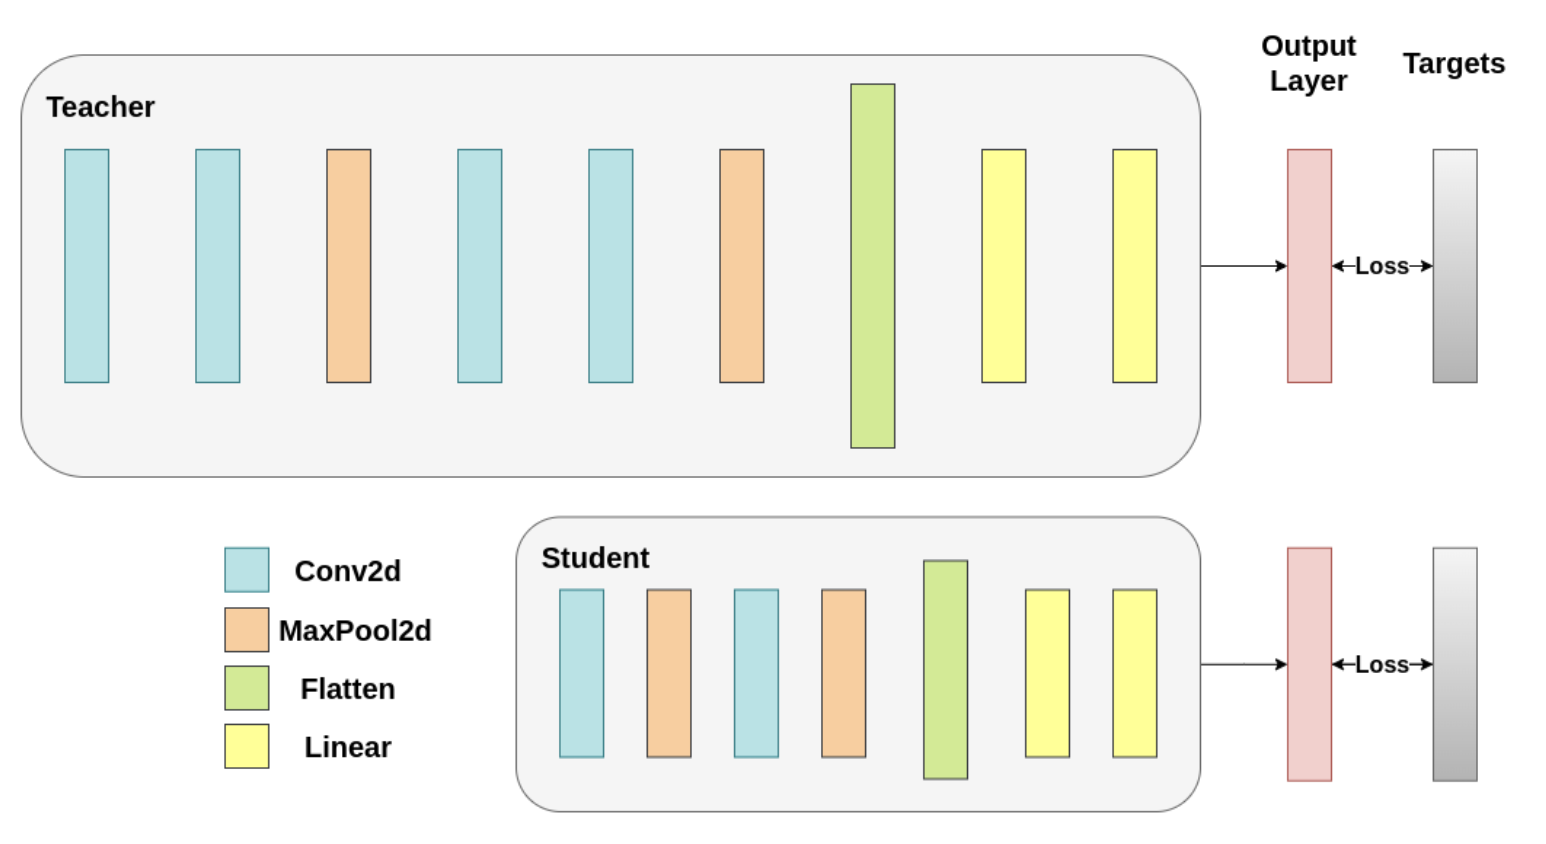

Now, we would be training both the networks with Cross-Entropy. Here, the student will be used as a baseline.

In [ ]:
import torch.optim as optim
def train(model, trainLoader, epochs, learning_rate, device):
    criterion = neuralNetDeep.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        runningLoss = 0.0
        for inputs, labels in trainLoader:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {runningLoss / len(trainLoader)}")

def test(model, testLoader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Cross-entropy runs

Here, we must set the torch seed by hand to render it reproducible. It's logical to initialize the networks with identical weights so that we can compare them on equal footing because we train the networks differently. Train the teacher network first using cross-entropy:


In [ ]:
torch.manual_seed(42)
nnDeep = DeepNN(num_classes=10).to(device)
train(nnDeep, trainLoader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nnDeep, testLoader, device)

torch.manual_seed(42)
nnLight = LightNN(num_classes=10).to(device)

Epoch 1/10, Loss: 1.3323189947001464
Epoch 2/10, Loss: 0.8651694140165967
Epoch 3/10, Loss: 0.6833443981607247
Epoch 4/10, Loss: 0.5355910462948977
Epoch 5/10, Loss: 0.4219740263336455
Epoch 6/10, Loss: 0.31987819266136347
Epoch 7/10, Loss: 0.22893391214215847
Epoch 8/10, Loss: 0.17531647197806927
Epoch 9/10, Loss: 0.1478926243493929
Epoch 10/10, Loss: 0.12633428377244632


We are initializing yet another light-weight model network to be compared to the performances of them. We are conscious of back propagation sensitivity toward weight initialization and thus expect both of these two networks to utilize the same initialization.

In [ ]:
torch.manual_seed(42)
updatedNNLight = LightNN(num_classes=10).to(device)

In [ ]:
print("Norm of 1st layer of nnLight is given as :", torch.norm(nnLight.features[0].weight).item())
print("Norm of 1st layer of updatedNNLight is given as:", torch.norm(updatedNNLight.features[0].weight).item())

Norm of 1st layer of nnLight is given as : 2.327361822128296
Norm of 1st layer of updatedNNLight is given as: 2.327361822128296


In [ ]:
allDeepparams = "{:,}".format(sum(p.numel() for p in nnDeep.parameters()))
print(f"DeepNN parameters are given by: {allDeepparams}")
allLightParams = "{:,}".format(sum(p.numel() for p in nnLight.parameters()))
print(f"LightNN parameters are given by: {allLightParams}")

DeepNN parameters are given by: 1,186,986
LightNN parameters are given by: 267,738


Please see below for training and testing the lightweight network with cross entropy loss.

In [ ]:
train(nnLight, trainLoader, epochs=10, learning_rate=0.001, device=device)
testAccLight = test(nnLight, testLoader, device)

Epoch 1/10, Loss: 1.4707028036532195
Epoch 2/10, Loss: 1.1606945866514045
Epoch 3/10, Loss: 1.027597018824819
Epoch 4/10, Loss: 0.9253809697487775
Epoch 5/10, Loss: 0.8494792763534409
Epoch 6/10, Loss: 0.7831004761978794
Epoch 7/10, Loss: 0.7188545287874959
Epoch 8/10, Loss: 0.6592967350159764
Epoch 9/10, Loss: 0.6070795640768603
Epoch 10/10, Loss: 0.5564694378686987


Here, we are able to compare the more complex network to be used as a teacher with the simple network that is our test student based on test accuracy. As our student has not yet interfered with the teacher, this performance has been achieved by the student completely. The values are as given in the print statements below.


In [ ]:
print(f"Teacher accuracy is given as: {test_accuracy_deep:.2f}%")
print(f"Student accuracy is given as: {testAccLight:.2f}%")

Teacher accuracy is given as: 74.78%
Student accuracy is given as: 70.40%


Knowledge distillation run

A couple of extra parameters are required as we proceed with constructing our initial helper function introducing a teacher-student dynamic:

1. T: Temperature controls smoothness of the output distributions. Lower probabilities receive a larger boost when T is large because smoother distributions are produced.

2. soft_target_loss_weight: Weight for the secondary objective we are about to introduce.

3. ce_loss_weight: Weight is given to cross-entropy. The weights are adjusted to force the network to optimize towards either goal.

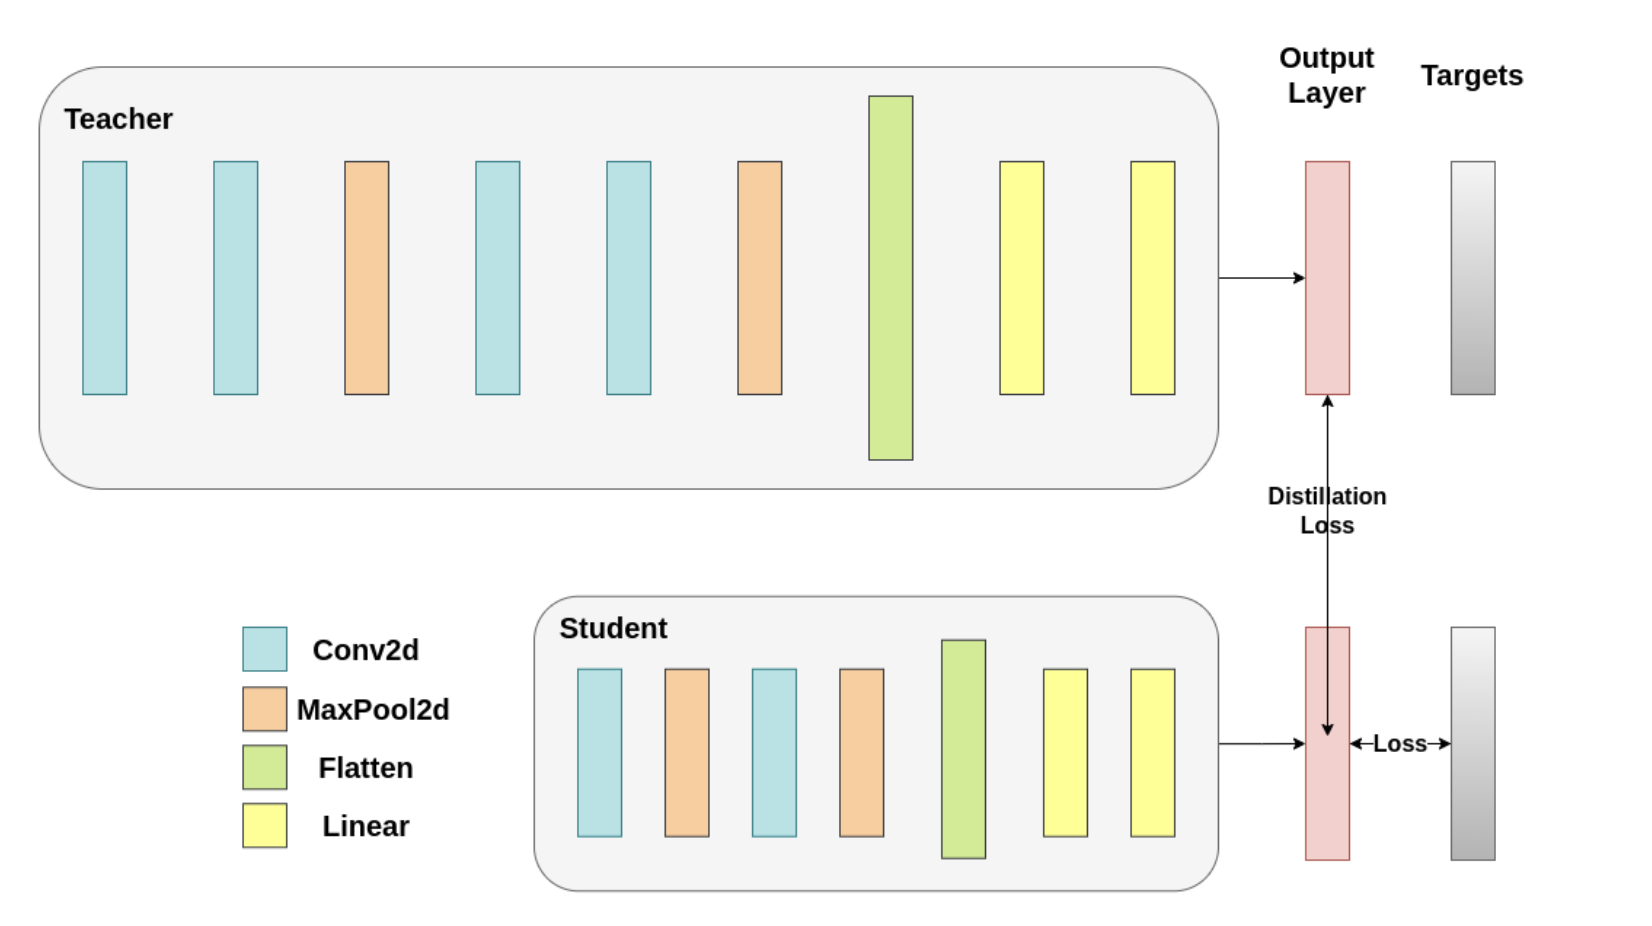

Distillation loss is calculated from the logits of or neural networks. It would be only returning gradients to the student.

In [ ]:
def trainKD(teacher, student, trainLoader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = neuralNetDeep.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher is set to evaluation mode
    student.train() # Student is set to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            soft_targets = neuralNetDeep.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = neuralNetDeep.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            label_loss = ce_loss(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainLoader)}")

# Apply ``trainKD`` approach with a temperature of 2. Need to set the weights to 0.75 for CE and 0.25 for distillation loss.
trainKD(teacher=nnDeep, student=updatedNNLight, trainLoader=trainLoader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
testAccLightCEandKD = test(updatedNNLight, testLoader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy is given as: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher is given as: {testAccLight:.2f}%")
print(f"Student accuracy with CE + KD is given as: {testAccLightCEandKD:.2f}%")

Epoch 1/10, Loss: 2.3531543315219148
Epoch 2/10, Loss: 1.837848301128963
Epoch 3/10, Loss: 1.6160908004511958
Epoch 4/10, Loss: 1.4527354514812265
Epoch 5/10, Loss: 1.3290953003537014
Epoch 6/10, Loss: 1.2142025985376304
Epoch 7/10, Loss: 1.1237343226552314
Epoch 8/10, Loss: 1.0388338573448492
Epoch 9/10, Loss: 0.9666390928161114
Epoch 10/10, Loss: 0.8920289810051394
Teacher accuracy is given as: 74.78%
Student accuracy without teacher is given as: 70.40%
Student accuracy with CE + KD is given as: 70.69%


Cosine loss minimization run.

Formula for cosine embedding loss is given below.

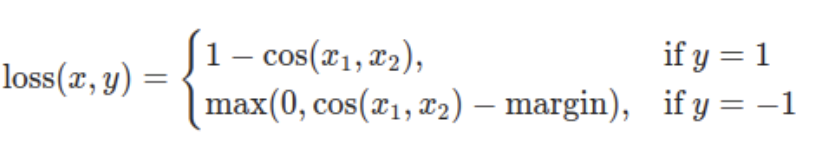

In [ ]:
class ModifiedDeepNNCosine(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 128, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(128, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(64, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(64, 32, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(2048, 512),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(512, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        flattened_conv_output = torch.flatten(xVar, 1)

        xVar = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = F.avg_pool1d(
            flattened_conv_output.unsqueeze(1),
            kernel_size=2
        ).squeeze(1)

        return xVar, flattened_conv_output_after_pooling

class ModifiedLightNNCosine(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(16, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(1024, 256),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(256, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        flattened_conv_output = torch.flatten(xVar, 1)
        xVar = self.classifier(flattened_conv_output)
        return xVar, flattened_conv_output

updatedNNDeepVal = ModifiedDeepNNCosine(num_classes=10).to(device)
updatedNNDeepVal.load_state_dict(nnDeep.state_dict())

print("Norm of 1st layer for nnDeep is:", torch.norm(nnDeep.features[0].weight).item())
print("Norm of 1st layer for updatedNNDeepVal is:", torch.norm(updatedNNDeepVal.features[0].weight).item())

torch.manual_seed(42)
modifiedNNLight = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer is:", torch.norm(modifiedNNLight.features[0].weight).item())

Norm of 1st layer for nnDeep is: 7.526727676391602
Norm of 1st layer for updatedNNDeepVal is: 7.526727676391602
Norm of 1st layer is: 2.327361822128296


Usually, we would need to change the train loop as, now the model returns a tuple (considering both logits, hiddenRepresentation). Now, we will be using a sample input tensor so that we can print their shapes.

In [ ]:
import torch.nn as neuralNetDeep
input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

logits, hiddenRepresentation = modifiedNNLight(input)

# Printing the shapes of the tensors
print("Student logits shape is given as:", logits.shape)
print("Student hidden representation shape:", hiddenRepresentation.shape)

# Pass the input through the teacher
logits, hiddenRepresentation = updatedNNDeepVal(input)

# Printing the shapes of the tensors
print("Teacher logits shape:", logits.shape)
print("Teacher hidden representation shape:", hiddenRepresentation.shape)

Student logits shape is given as: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


The hiddenRepresentation in our example is 1024. You see, here is the student's last convolutional layer's flattened feature map that we use as input for the classifier. As we constructed it so using avg_pool1d from 2048, it is 1024 for the teacher as well. Only the student's weights before loss calculation are influenced by the loss used here. That is, it does not affect the student's classifier in any way. The new training loop is shown below:

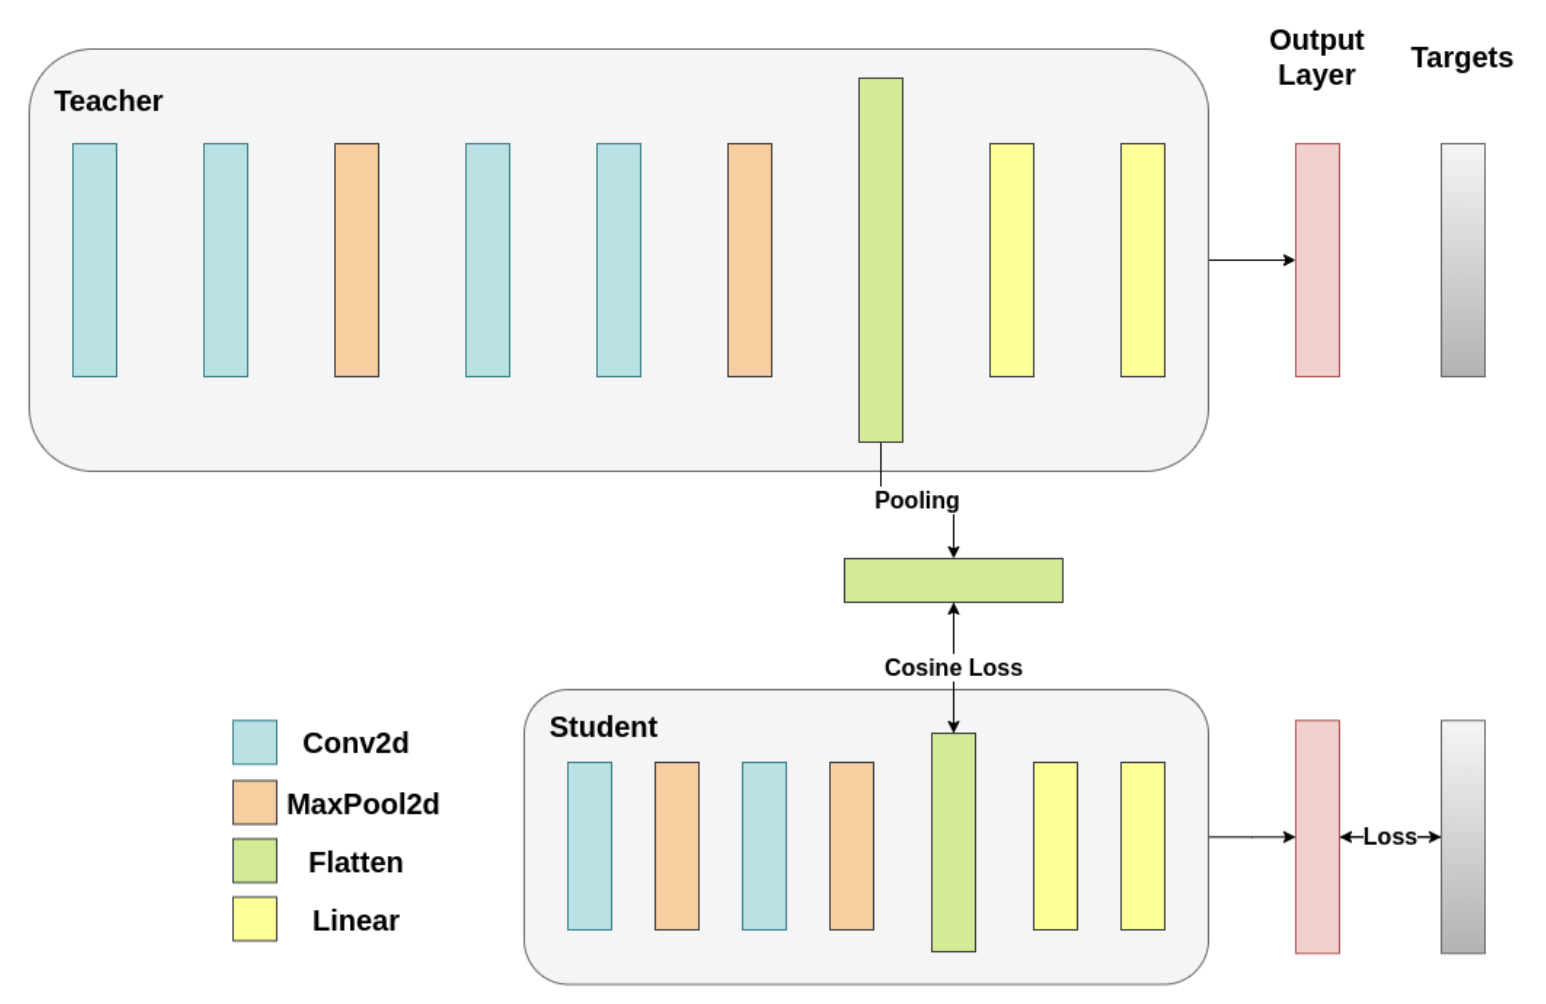

By giving the student gradients back, we hope to optimize the cosine similarity between the two representations in Cosine Loss minimization:


In [ ]:
def train_cosine_loss(teacher, student, trainLoader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = neuralNetDeep.CrossEntropyLoss()
    cosine_loss = neuralNetDeep.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                _, teacherHiddenRep = teacher(inputs)

            student_logits, studentHiddenRep = student(inputs)

            hidden_rep_loss = cosine_loss(studentHiddenRep, teacherHiddenRep, target=torch.ones(inputs.size(0)).to(device))

            label_loss = ce_loss(student_logits, labels)

            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch is {epoch+1}/{epochs}, Loss is: {running_loss / len(trainLoader)}")

In [ ]:
def testVaruiousOutputs(model, testLoader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:

train_cosine_loss(teacher=updatedNNDeepVal, student=modifiedNNLight, trainLoader=trainLoader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_acc_light_CE_Cosine = testVaruiousOutputs(modifiedNNLight, testLoader, device)

Epoch is 1/10, Loss is: 0.9272697993251674
Epoch is 2/10, Loss is: 0.8609864047116331
Epoch is 3/10, Loss is: 0.8101726611861793
Epoch is 4/10, Loss is: 0.766938942167765
Epoch is 5/10, Loss is: 0.7310676859772723
Epoch is 6/10, Loss is: 0.690351504956365
Epoch is 7/10, Loss is: 0.6627051261684779
Epoch is 8/10, Loss is: 0.6280967103093481
Epoch is 9/10, Loss is: 0.6022845853472609
Epoch is 10/10, Loss is: 0.5727365791340313
Test Accuracy: 71.31%


Intermediate regressor run

In [ ]:
convOutputFEStudent = nnLight.features(input)
convOutputFETeacher = nnDeep.features(input)

print("Student's feature extractor output shape is given as: ", convOutputFEStudent.shape)
print("Teacher's feature extractor output shape is given as: ", convOutputFETeacher.shape)

Student's feature extractor output shape is given as:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape is given as:  torch.Size([128, 32, 8, 8])


We have sixteen teacher filters and thirty-two student filters. We will add a trainability layer that will transform the feature map of the student into the feature map shape of the teacher. In actuality, we have changed the teacher class to give the output of the last convolutional layer without flattening or pooling, and the lightweight class to give the hidden state after an intermediate regressor that adjusts the convolutional feature map sizes.

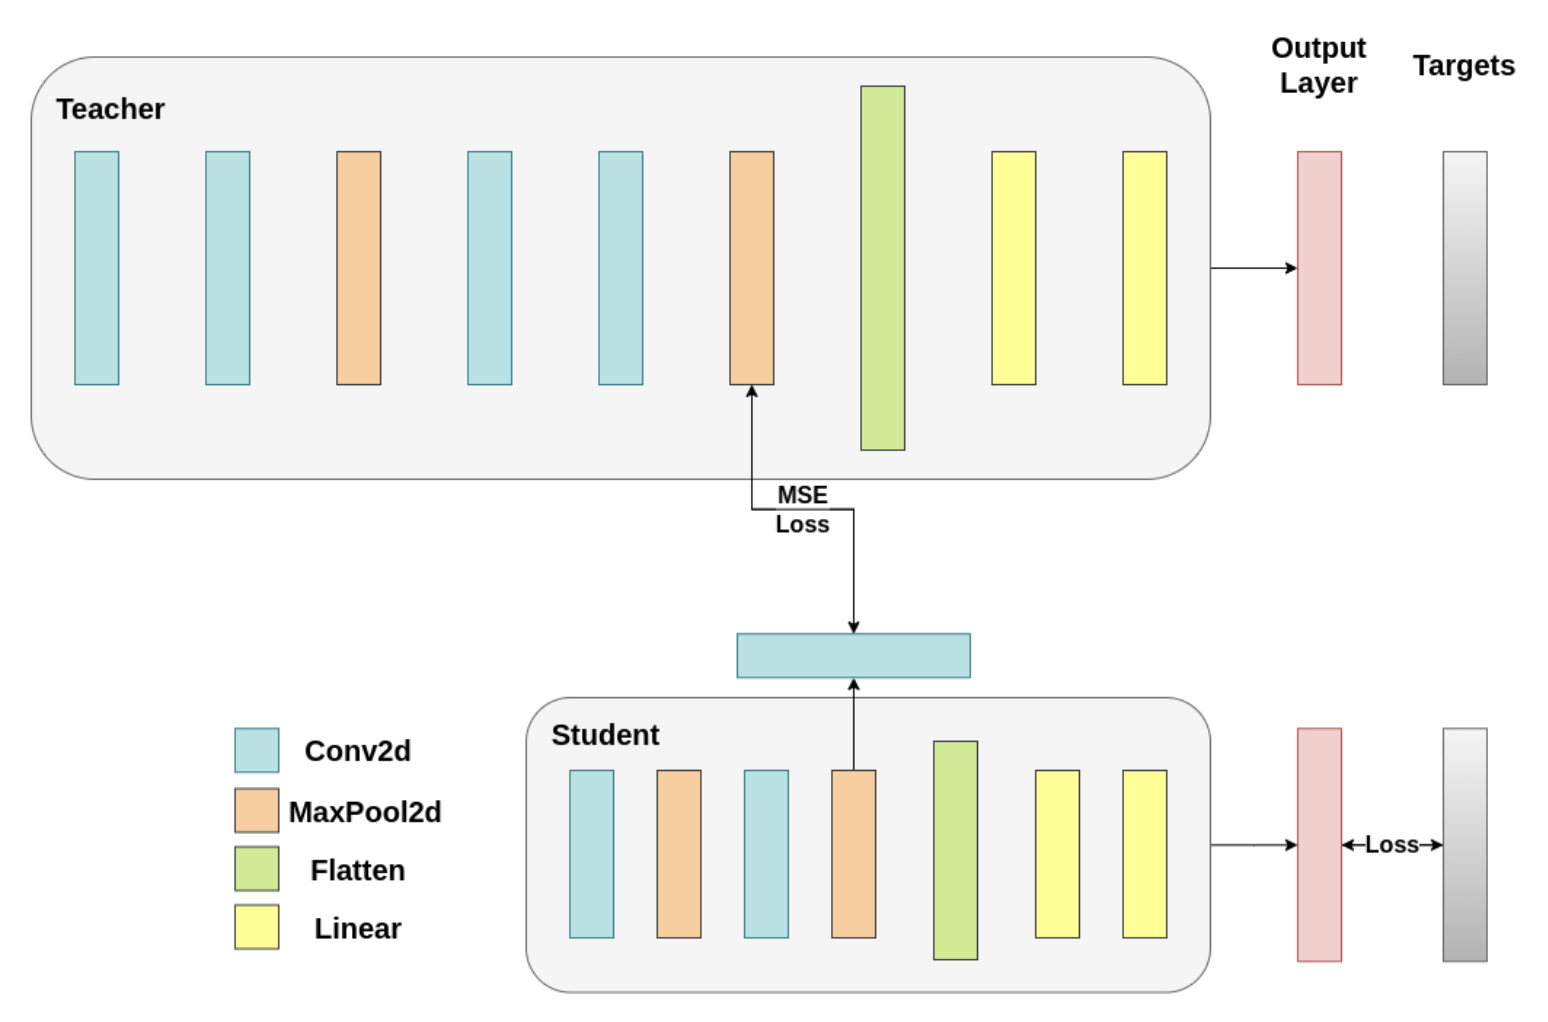

The trainable layer would be matching with the shapes of the intermediate tensors & Mean Squared Error (MSE) will be properly defined.

In [ ]:
class ModifiedDeepNNRegressor(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 128, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(128, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(64, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Conv2d(64, 32, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(2048, 512),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(512, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        conv_feature_map = xVar
        xVar = torch.flatten(xVar, 1)
        xVar = self.classifier(xVar)
        return xVar, conv_feature_map

class ModifiedLightNNRegressor(neuralNetDeep.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(3, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
            neuralNetDeep.Conv2d(16, 16, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),
        )
        self.regressor = neuralNetDeep.Sequential(
            neuralNetDeep.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(1024, 256),
            neuralNetDeep.ReLU(),
            neuralNetDeep.Dropout(0.1),
            neuralNetDeep.Linear(256, num_classes)
        )

    def forward(self, xVar):
        xVar = self.features(xVar)
        regressor_output = self.regressor(xVar)
        xVar = torch.flatten(xVar, 1)
        xVar = self.classifier(xVar)
        return xVar, regressor_output

In [ ]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = neuralNetDeep.CrossEntropyLoss()
    mse_loss = neuralNetDeep.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            student_logits, regressor_feature_map = student(inputs)

            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            label_loss = ce_loss(student_logits, labels)

            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch is {epoch+1}/{epochs}, Loss is: {running_loss / len(train_loader)}")

torch.manual_seed(42)
updatedNNLightReg = ModifiedLightNNRegressor(num_classes=10).to(device)

updatedNNDeepReg = ModifiedDeepNNRegressor(num_classes=10).to(device)
updatedNNDeepReg.load_state_dict(nnDeep.state_dict())

train_mse_loss(teacher=updatedNNDeepReg, student=updatedNNLightReg, train_loader= trainLoader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
testAccLightCeMseLoss = testVaruiousOutputs(updatedNNLightReg, testLoader, device)

Epoch is 1/10, Loss is: 1.686122543976435
Epoch is 2/10, Loss is: 1.3139424555746795
Epoch is 3/10, Loss is: 1.1684237375588673
Epoch is 4/10, Loss is: 1.074315767306501
Epoch is 5/10, Loss is: 0.9956137460211049
Epoch is 6/10, Loss is: 0.9361885941546896
Epoch is 7/10, Loss is: 0.8814991967147573
Epoch is 8/10, Loss is: 0.8338966503777467
Epoch is 9/10, Loss is: 0.792349142491665
Epoch is 10/10, Loss is: 0.7566778269570197
Test Accuracy: 70.49%


In [ ]:
print(f"Teacher accuracy is given as: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher is given as: {testAccLight:.2f}%")
print(f"Student accuracy with CE + KD is given as: {testAccLightCEandKD:.2f}%")
print(f"Student accuracy with CE + CosineLoss is given as: {test_acc_light_CE_Cosine:.2f}%")
print(f"Student accuracy with CE + RegressorMSE is given as: {testAccLightCeMseLoss:.2f}%")

Teacher accuracy is given as: 74.78%
Student accuracy without teacher is given as: 70.40%
Student accuracy with CE + KD is given as: 70.69%
Student accuracy with CE + CosineLoss is given as: 71.31%
Student accuracy with CE + RegressorMSE is given as: 70.49%


Since none of the previously described methods increase the amount of network parameters or the inference time, the performance gain comes at the slight cost of computing gradients during training. In machine learning applications, inference time is of the utmost importance since training is completed before model deployment. In the event that our light model is still too large for deployment, we can also use post-training quantization. Apart from adjusting variables such as temperature, number of neurons, or coefficients, you can also experiment with adding more losses to certain jobs.

References

1. https://neptune.ai/blog/knowledge-distillation
2. https://labelbox.com/guides/knowledge-distillation/
3. https://en.wikipedia.org/wiki/Knowledge_distillation
4. https://www.kaggle.com/code/lonnieqin/knowledge-distillation
